In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from IPython.display import display, Markdown

import sys
sys.path.append('.')

from util import (
  draw_graphs as _draw_graphs
)
from pipeline import make_pipeline

from mcopt import ot, MorseGraph

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from scipy.spatial import ConvexHull

In [4]:
pipeline = make_pipeline()

bi_simple = pipeline.dataset('binary_gaussian_simple')
tri_simple = pipeline.dataset('trinary_gaussian_simple')

display(Markdown(bi_simple.display_description()))
display(Markdown(tri_simple.display_description()))


# Binary Gaussian Simple


A toy example in which 2 gaussian functions with $\sigma = 5$ are placed
in the center.

There are 100 frames which each rotate the gaussian's roughly 3 degrees.
 



# Trinary Gaussian Simple


A toy example in which 3 gaussian functions with $\sigma = 5$ are placed
in the center.

There are 100 frames which each rotate the gaussian's roughly 3 degrees.
 


In [5]:
graphs = pipeline.graph('gaussian_simple').build()
mds_gw = pipeline.mds('gaussian_simple_gw').build()
mds_fgw = pipeline.mds('gaussian_simple_fgw').build()
mds_wasserstein = pipeline.mds('gaussian_simple_wasserstein').build()

> [graph:gaussian_simple] building


  saving to /workspaces/MCOpt/experiments/__pipeline_cache__/graph/gaussian_simple
> [mds:gaussian_simple_gw] config unchanged, loading
> [mds:gaussian_simple_fgw] config unchanged, loading
> [mds:gaussian_simple_wasserstein] config unchanged, loading


In [6]:
gw = pipeline.couplings('gaussian_simple_gw').build()


> [couplings:gaussian_simple_gw] config unchanged, loading


In [7]:
train_prop = 0.05

bi_is = np.asarray(list(graphs.index_map[0].values()))

bi_train_is, bi_test_is = train_test_split(bi_is, train_size=train_prop, random_state=42)

tri_is = np.asarray(list(graphs.index_map[1].values()))

tri_train_is, tri_test_is = train_test_split(tri_is, train_size=train_prop, random_state=42)

train_is = np.hstack([bi_train_is, tri_train_is])
test_is = np.hstack([bi_test_is, tri_test_is])

nearest_neighbors = KNeighborsClassifier(metric='precomputed')

X_train = gw.distances[train_is, :][:, train_is]
Y_train = np.where([i in bi_is for i in train_is], 0, 1)

X_test = gw.distances[test_is, :][:, train_is]
Y_test = np.where([i in bi_is for i in test_is], 0, 1)

nearest_neighbors.fit(X_train, Y_train)

nearest_neighbors.score(X_test, Y_test)

1.0

In [60]:
X = gw.distances[:, train_is]
Y_true = np.where([i in bi_is for i in range(200)], 0, 1)

nearest_neighbors.score(X, Y_true)

1.0

In [8]:

Y = nearest_neighbors.predict(X)

bi_pred = np.argwhere(Y == 0).ravel()
tri_pred = np.argwhere(Y == 1).ravel()

In [50]:
transform = mds_gw.transform

bi_hull = ConvexHull(transform[bi_pred])
tri_hull = ConvexHull(transform[tri_pred])

Text(0.5, 1.0, 'GW')

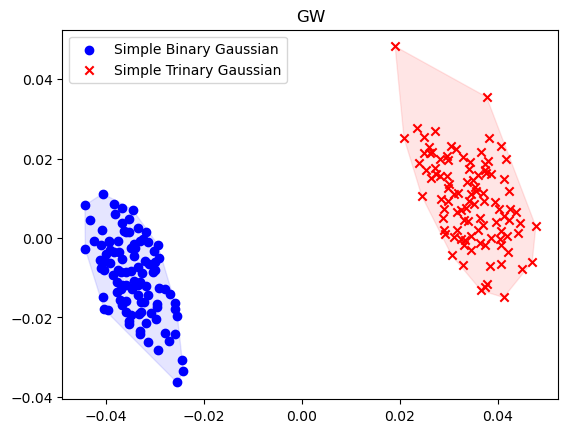

In [53]:
fig, ax = plt.subplots()

markers = ['o', 'x']
colors = ['blue', 'red']
labels = ['Simple Binary Gaussian', 'Simple Trinary Gaussian',]

bi_hull_points = transform[bi_pred][bi_hull.vertices]
ax.fill(bi_hull_points[:, 0], bi_hull_points[:, 1], c=colors[0], alpha=0.10)

tri_hull_points = transform[tri_pred][tri_hull.vertices]
ax.fill(tri_hull_points[:, 0], tri_hull_points[:, 1], c=colors[1], alpha=0.10)

for i, (class_transform, marker, color, label) in enumerate(zip(mds_gw.class_transforms, markers, colors, labels)):
  ax.scatter(
    class_transform[:, 0], 
    class_transform[:, 1], 
    marker=marker, 
    c=color, 
    label=label
  )
  
ax.legend()
ax.set_title('GW')